In [1]:
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt

In [2]:
merged_df = pd.read_csv('data/r_results.csv')
n_seq = 63

In [3]:
merged_df['error'] = merged_df['forecast'] - merged_df['Close']
merged_df['abs_error'] = np.abs(merged_df['forecast'] - merged_df['Close'])

merged_df['actual_up'] = merged_df['Close'].diff(1) > 0
merged_df['forecast_up'] = merged_df['forecast'].diff(1) > 0

def confusion(actual, forecast):
    if (actual and forecast):
        return 'TP'
    
    if (actual and not forecast):
        return 'FN'
    
    if (not actual and forecast):
        return 'FP'
    
    if (not actual and not forecast):
        return 'TN'
    
    return False

merged_df['confusion'] = merged_df.apply(lambda x: confusion(x['actual_up'], x['forecast_up']), axis=1)

merged_df.tail()

,Exchange.Date,Close,logreturns,forecast,error,abs_error,actual_up,forecast_up,confusion
3481,42663,671.89,0.005567,657.637739,-14.252261,14.252261,True,True,TP
3482,42664,671.08,-0.001206,658.205370,-12.874630,12.874630,False,True,FP
3483,42667,668.82,-0.003373,658.773490,-10.046510,10.046510,False,True,FP
3484,42668,668.02,-0.001197,659.342101,-8.677899,8.677899,False,True,FP
3485,42669,663.33,-0.007046,659.911202,-3.418798,3.418798,False,True,FP


In [4]:
# New dataframe that only contains the number of periods to evaluate (1,3,5,21,63)
def new_df(n_periods):
    start = -n_seq
    end = -n_seq + n_periods if n_periods != 63 else None
    df = merged_df[start : end]
    return df

In [5]:
# Calculating RMSE and MAE
def evaluate(n_periods):
    df = new_df(n_periods)
    mape = ((df['abs_error'] / df['Close']).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df['error'].sum(), 2) / n_periods)
    print(f"{n_periods}, RMSE: {round(rmse, 3)}, MAPE: {round(mape, 3)}%")

evaluate(1) # 1 day
evaluate(3) # half a week
evaluate(5) # week
evaluate(21) # month
evaluate(63) # quarter

1, RMSE: 0.025, MAPE: 0.004%
3, RMSE: 7.525, MAPE: 0.706%
5, RMSE: 9.852, MAPE: 0.713%
21, RMSE: 2.324, MAPE: 0.541%
63, RMSE: 43.548, MAPE: 1.063%


In [6]:
# Creating confusion matrix
def confusion_matrix(df):
    conf = pd.DataFrame(columns=['P', 'N'], index=['P', 'N'])
    conf.loc['P', 'P'] = len(df[df['confusion'] == 'TP'])
    conf.loc['P', 'N'] = len(df[df['confusion'] == 'FN'])
    conf.loc['N', 'P'] = len(df[df['confusion'] == 'FP'])
    conf.loc['N', 'N'] = len(df[df['confusion'] == 'TN'])
    return conf

confusion = confusion_matrix(new_df(21))
precision = confusion.iloc[0, 0] / (confusion.iloc[0,0] + confusion.iloc[0,1])
recall = confusion.iloc[0, 0] / (confusion.iloc[0,0] + confusion.iloc[1,0])
f_score = 2*precision*recall/(precision+recall)

print(confusion)
print(f'precision: {int(precision*100)}%, recall: {int(recall*100)}%, f-score: {round(f_score, 3)}')

    P  N
P  13  0
N   8  0
precision: 100%, recall: 61%, f-score: 0.765


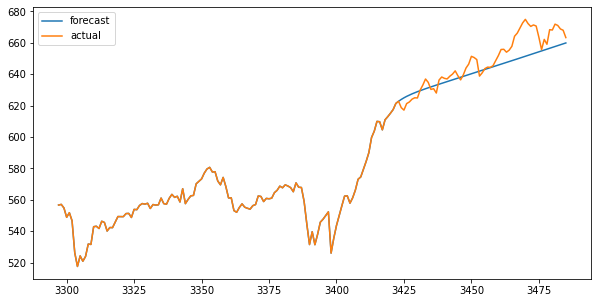

In [15]:
plot_df = merged_df[-n_seq - (n_seq*2) :]
plt.figure(figsize=(10, 5))
plt.plot(plot_df['forecast'], label="forecast")
plt.plot(plot_df['Close'], label="actual")
plt.legend()